## DDQN in Simpler Environments

Base implementation adapted from HW7

In [1]:
import time

import numpy as np
import gymnasium as gym
import torch
from gymnasium import spaces
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from DQN import DQNAgent

In [2]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [3]:
class DiscreteActionWrapper(gym.ActionWrapper):
    def __init__(self, env: gym.Env, bins = 5):
        """A wrapper for converting a 1D continuous actions into discrete ones.
        Args:
            env: The environment to apply the wrapper
            bins: number of discrete actions
        """
        assert isinstance(env.action_space, spaces.Box)
        super().__init__(env)
        self.bins = bins
        self.orig_action_space = env.action_space
        self.action_space = spaces.Discrete(self.bins)

    def action(self, action):
        """ discrete actions from low to high in 'bins'
        Args:
            action: The discrete action
        Returns:
            continuous action
        """
        return self.orig_action_space.low + action/(self.bins-1.0)*(self.orig_action_space.high-self.orig_action_space.low)  

## DQN
Test DQN implementation on simple environments

### Pendulum

In [4]:
RENDER = False
ENV_NAME = 'Pendulum-v1'

if RENDER:
    env = gym.make(ENV_NAME, render_mode='human')
else:
    env = gym.make(ENV_NAME)

if isinstance(env.action_space, spaces.Box):
    env = DiscreteActionWrapper(env,5)

ac_space = env.action_space
o_space = env.observation_space
print("Env. action space:")
print(ac_space)
print("Env. observation space:")
print(o_space)
#print(list(zip(env.observation_space.low, env.observation_space.high)))

Env. action space:
Discrete(5)
Env. observation space:
Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)


In [5]:
DISCOUNT = 0.95
EPS = 0.2
USE_TARGET = True
TARGET_UPDATE = 20

q_agent = DQNAgent(
    o_space,
    ac_space,
    discount=DISCOUNT,
    eps=EPS,
    use_target_net=USE_TARGET,
    update_target_every=TARGET_UPDATE
)



In [6]:
ob, _info = env.reset()
q_agent.Q.predict(ob)

array([ 0.12190077, -0.1325621 , -0.15125003,  0.3347502 , -0.14507765],
      dtype=float32)

In [7]:
MAX_EPISODES=600
MAX_STEPS=500

#PRINT_FREQ=20
PRINT_FREQ=MAX_EPISODES

In [8]:
stats = []
losses = []

for i in tqdm(range(MAX_EPISODES)):
    # print("Starting a new episode")
    total_reward = 0
    ob, _info = env.reset()
    for t in range(MAX_STEPS):
        done = False
        a = q_agent.act(ob)
        (ob_new, reward, done, trunc, _info) = env.step(a)
        total_reward+= reward
        q_agent.store_transition((ob, a, reward, ob_new, done))            
        ob=ob_new        
        if done: break    
    losses.extend(q_agent.train(32))
    stats.append([i,total_reward,t+1])    
    
    if (i-1) % PRINT_FREQ == 0:
        print("{}: Done after {} steps. Reward: {}".format(i, t+1, total_reward))

  0%|          | 0/600 [00:00<?, ?it/s]

1: Done after 500 steps. Reward: -4560.792857672966


In [9]:
env.close()

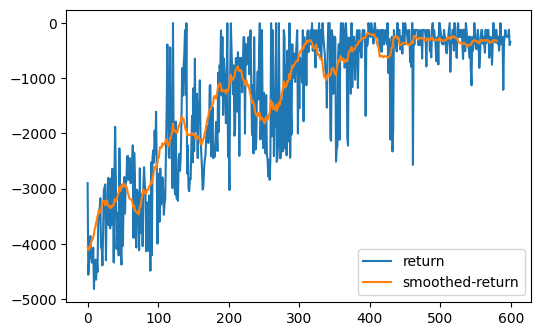

In [10]:
stats_np = np.asarray(stats)
losses_np = np.asarray(losses)
fig=plt.figure(figsize=(6,3.8))
plt.plot(stats_np[:,1], label="return")
plt.plot(running_mean(stats_np[:,1],20), label="smoothed-return")
plt.legend()

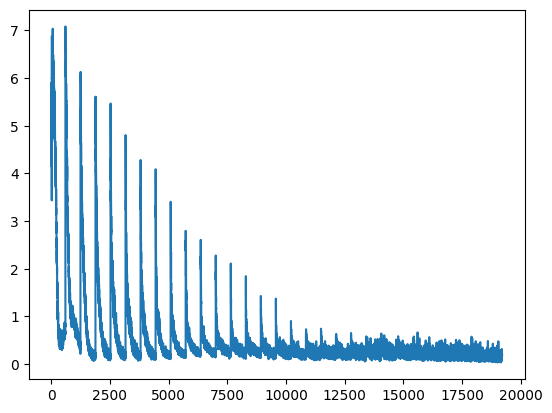

In [11]:
plt.figure()
plt.plot(losses_np)

In [12]:
# Display trained agent's performance
env = gym.make("Pendulum-v1", render_mode='human')
ob, _info = env.reset()
if isinstance(env.action_space, spaces.Box):
    env = DiscreteActionWrapper(env,5)

ac_space = env.action_space
o_space = env.observation_space

env.reset()
total_reward = 0
for t in range(500):
    a = q_agent.act(ob)
    (ob, reward, done, trunc, _info) = env.step(a)
    total_reward+= reward
    if done or trunc: break

print("Total reward:", total_reward)

Total reward: -386.32286345264026


In [13]:
env.close()

### LunarLander

In [45]:
RENDER = False
ENV_NAME = 'LunarLander-v3'

if RENDER:
    env = gym.make(ENV_NAME, render_mode='human')
else:
    env = gym.make(ENV_NAME)

if isinstance(env.action_space, spaces.Box):
    env = DiscreteActionWrapper(env,5)

ac_space = env.action_space
o_space = env.observation_space
print("Env. action space:")
print(ac_space)
print("Env. observation space:")
print(o_space)
#print(list(zip(env.observation_space.low, env.observation_space.high)))

Env. action space:
Discrete(4)
Env. observation space:
Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)


In [46]:
DISCOUNT = 0.95
EPS = 0.3
USE_TARGET = True
TARGET_UPDATE = 15

q_agent = DQNAgent(
    o_space,
    ac_space,
    discount=DISCOUNT,
    eps=EPS,
    use_target_net=USE_TARGET,
    update_target_every=TARGET_UPDATE
)


In [47]:
ob, _info = env.reset()
q_agent.Q.predict(ob)

array([-0.05865086, -0.13180715, -0.00160181, -0.05141127], dtype=float32)

In [48]:
MAX_EPISODES=1000
MAX_STEPS=600

#PRINT_FREQ=20
PRINT_FREQ=MAX_EPISODES

In [49]:
stats = []
losses = []

for i in tqdm(range(MAX_EPISODES)):
    # print("Starting a new episode")
    total_reward = 0
    ob, _info = env.reset()
    for t in range(MAX_STEPS):
        done = False
        a = q_agent.act(ob)
        (ob_new, reward, done, trunc, _info) = env.step(a)
        total_reward+= reward
        q_agent.store_transition((ob, a, reward, ob_new, done))            
        ob=ob_new        
        if done: break    
    losses.extend(q_agent.train(32))
    stats.append([i,total_reward,t+1])    
    
    if (i-1) % PRINT_FREQ == 0:
        print("{}: Done after {} steps. Reward: {}".format(i, t+1, total_reward))

  0%|          | 0/1000 [00:00<?, ?it/s]

1: Done after 54 steps. Reward: -320.4894486441242


In [ ]:
env.close()

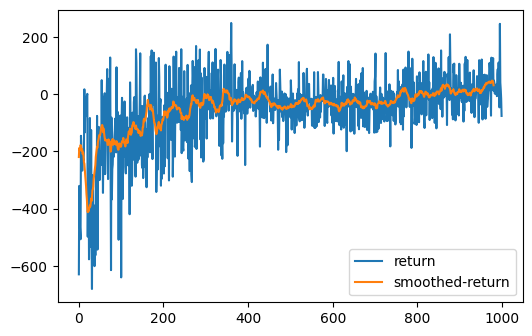

In [50]:
stats_np = np.asarray(stats)
losses_np = np.asarray(losses)
fig=plt.figure(figsize=(6,3.8))
plt.plot(stats_np[:,1], label="return")
plt.plot(running_mean(stats_np[:,1],20), label="smoothed-return")
plt.legend()

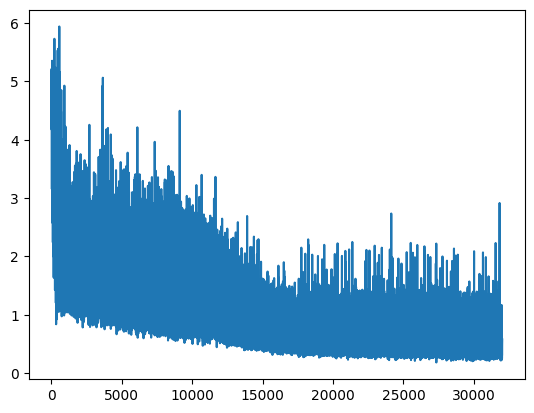

In [51]:
plt.figure()
plt.plot(losses_np)

In [52]:
# Display trained agent's performance
env = gym.make("LunarLander-v3", render_mode='human')
ob, _info = env.reset()
if isinstance(env.action_space, spaces.Box):
    env = DiscreteActionWrapper(env,5)

ac_space = env.action_space
o_space = env.observation_space

env.reset()
total_reward = 0
for t in range(500):
    a = q_agent.act(ob)
    (ob, reward, done, trunc, _info) = env.step(a)
    total_reward+= reward
    if done or trunc: break

print("Total reward:", total_reward)

Total reward: 40.01598708372427


In [53]:
env.close()

### CarRacing

In [54]:
RENDER = False
ENV_NAME = 'CarRacing-v3'

if RENDER:
    env = gym.make(ENV_NAME, render_mode='human')
else:
    env = gym.make(ENV_NAME)

if isinstance(env.action_space, spaces.Box):
    env = DiscreteActionWrapper(env,5)

ac_space = env.action_space
o_space = env.observation_space
print("Env. action space:")
print(ac_space)
print("Env. observation space:")
print(o_space)
#print(list(zip(env.observation_space.low, env.observation_space.high)))

Env. action space:
Discrete(5)
Env. observation space:
Box(0, 255, (96, 96, 3), uint8)


In [55]:
DISCOUNT = 0.95
EPS = 0.3
USE_TARGET = True
TARGET_UPDATE = 15

q_agent = DQNAgent(
    o_space,
    ac_space,
    discount=DISCOUNT,
    eps=EPS,
    use_target_net=USE_TARGET,
    update_target_every=TARGET_UPDATE
)


In [ ]:
ob, _info = env.reset()

q_agent.Q.predict(ob)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (9216x3 and 96x100)

In [ ]:
MAX_EPISODES=1000
MAX_STEPS=600

#PRINT_FREQ=20
PRINT_FREQ=MAX_EPISODES

In [ ]:
stats = []
losses = []

for i in tqdm(range(MAX_EPISODES)):
    # print("Starting a new episode")
    total_reward = 0
    ob, _info = env.reset()
    for t in range(MAX_STEPS):
        done = False
        a = q_agent.act(ob)
        (ob_new, reward, done, trunc, _info) = env.step(a)
        total_reward+= reward
        q_agent.store_transition((ob, a, reward, ob_new, done))            
        ob=ob_new        
        if done: break    
    losses.extend(q_agent.train(32))
    stats.append([i,total_reward,t+1])    
    
    if (i-1) % PRINT_FREQ == 0:
        print("{}: Done after {} steps. Reward: {}".format(i, t+1, total_reward))

In [ ]:
env.close()

In [ ]:
stats_np = np.asarray(stats)
losses_np = np.asarray(losses)
fig=plt.figure(figsize=(6,3.8))
plt.plot(stats_np[:,1], label="return")
plt.plot(running_mean(stats_np[:,1],20), label="smoothed-return")
plt.legend()

In [ ]:
plt.figure()
plt.plot(losses_np)

In [ ]:
# Display trained agent's performance
env = gym.make("CarRacing-v3", render_mode='human')
ob, _info = env.reset()
if isinstance(env.action_space, spaces.Box):
    env = DiscreteActionWrapper(env,5)

ac_space = env.action_space
o_space = env.observation_space

env.reset()
total_reward = 0
for t in range(500):
    a = q_agent.act(ob)
    (ob, reward, done, trunc, _info) = env.step(a)
    total_reward+= reward
    if done or trunc: break

print("Total reward:", total_reward)

In [ ]:
env.close()

## DDQN

Test DDQN implementation on simple environments

In [ ]:
...